## Подключение вспомогательных библиотек

In [ ]:
!pip install ultralytics==8.3.115

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.5/983.5 kB 18.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found exi

In [ ]:
import ultralytics
import datasets
import torch
import torch.nn

import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import torch.nn.functional as F
import torchvision.models
import numpy as np
import yaml
import torch.utils.data
import torchvision.transforms
import torch.optim
from torchmetrics.detection.mean_ap import MeanAveragePrecision

from pathlib import Path
from PIL import Image

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current device is: {DEVICE}")

Current device is: cuda


## 1. Выбор начальных условий

Для решения задачи обнаружения и распознования объектов на основе визуальных данных я также, как и в прошлых лабораторных работах, выбрал датасет [`Nfiniteai/product-masks-sample`](https://huggingface.co/datasets/Nfiniteai/product-masks-sample) с платформы Hugging Face. Этот датасет содержит изображения, сгенерированные из 3D моделей объектов, обычно встречающихся в домашней и гостиной обстановке. Так как изображения выполнены в фотореалистичном стиле, то это позволяет использовать их для обучения моделей с высокой степенью реалистичности.

Такой датасет в контексте задачи обнаружения и распознования объектов может пригодиться для решения задач, связанных с системой инвентаризации, к примеру автоматической распознование объектов по камере.

Скачаем датасет при помощи библиотеки `datasets` и продемонстрируем его краткое содержимое.

In [ ]:
dataset = datasets.load_dataset('Nfiniteai/product-masks-sample')

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Validation dataset size: {len(dataset['val'])}")

print('Features:')
for feature_name, feature_type in dataset['train'].features.items():
    print(f'{feature_name}: {feature_type}')

README.md:   0%|          | 0.00/3.54k [00:00<?, ?B/s]

train-00000-of-00014.parquet:   0%|          | 0.00/345M [00:00<?, ?B/s]

train-00001-of-00014.parquet:   0%|          | 0.00/251M [00:00<?, ?B/s]

train-00002-of-00014.parquet:   0%|          | 0.00/283M [00:00<?, ?B/s]

train-00003-of-00014.parquet:   0%|          | 0.00/305M [00:00<?, ?B/s]

train-00004-of-00014.parquet:   0%|          | 0.00/298M [00:00<?, ?B/s]

train-00005-of-00014.parquet:   0%|          | 0.00/223M [00:00<?, ?B/s]

train-00006-of-00014.parquet:   0%|          | 0.00/214M [00:00<?, ?B/s]

train-00007-of-00014.parquet:   0%|          | 0.00/253M [00:00<?, ?B/s]

train-00008-of-00014.parquet:   0%|          | 0.00/265M [00:00<?, ?B/s]

train-00009-of-00014.parquet:   0%|          | 0.00/275M [00:00<?, ?B/s]

train-00010-of-00014.parquet:   0%|          | 0.00/213M [00:00<?, ?B/s]

train-00011-of-00014.parquet:   0%|          | 0.00/269M [00:00<?, ?B/s]

train-00012-of-00014.parquet:   0%|          | 0.00/233M [00:00<?, ?B/s]

train-00013-of-00014.parquet:   0%|          | 0.00/198M [00:00<?, ?B/s]

val-00000-of-00001.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2559 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/151 [00:00<?, ? examples/s]

Train dataset size: 2559
Validation dataset size: 151
Features:
image_id: Value(dtype='string', id=None)
image: Image(mode=None, decode=True, id=None)
mask: Image(mode=None, decode=True, id=None)
category: Value(dtype='string', id=None)
bbox: Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None)
product_id: Value(dtype='string', id=None)
scene_id: Value(dtype='string', id=None)


### Выбор метрик

​Для задачи обнаружения и распознавания объектов важно использовать метрики, которые объективно оценивают качество предсказаний модели с учётом особенностей задачи, таких как многоклассовость, точность локализации и способность модели различать объекты на разных уровнях уверенности.​

В рамках решения лабораторной работы были использованы следующие метрики:

- **mAP50**. Данная метрика представляет собой среднюю точность
  точность при пороге IoU, равном `0.5`.​ Такая метрика используется
  для оценки модели при более низком пороге точности,
  что позволяет выявить её способность обнаруживать объекты
  с меньшей точностью.​

- **mAP50-95**. Предоставляет более строгую и сбалансированную оценку
  производительности модели. Она предоставляет информацию о
  способности модели обнаруживать объекты при менее строгих условиях. Такую метрику обычно используют для общей оценки производительности модели,
  так как она предоставляет сбалансированную оценку точности обнаружения
  объектов при различных порогах IoU.


## 2. Создание бейзлайна и оценка качества

Перейдем к формированию бейзлайна. Аналогично с прошлыми лабораторными работами, выполним минимальное преобразование скачанного датасета, чтобы он был пригоден для обучения модели.

Для этого выполним нормализацию названий классов и уберем из тренировочной выборки те записи, в которых есть классы, не предусмотренные в валидационной выборке. Также, уберем все лишние поля, которые нам не понадобятся при обучении в целях экономии памяти.

In [ ]:
val_dataset = dataset['val']
train_dataset = dataset['train']

In [ ]:
def preprocess_category(category):
    return category.lower().replace(' ', '_')

def preprocess_category_batch(batch):
    batch['category'] = [preprocess_category(el) for el in batch['category']]
    return batch

val_dataset = val_dataset.map(
    preprocess_category_batch,
    load_from_cache_file=False,
    batched=True,
    batch_size=300,
    writer_batch_size=300,
)

train_dataset = train_dataset.map(
    preprocess_category_batch,
    load_from_cache_file=False,
    batched=True,
    batch_size=300,
    writer_batch_size=300,
)

Map:   0%|          | 0/151 [00:00<?, ? examples/s]

Map:   0%|          | 0/2559 [00:00<?, ? examples/s]

Выполним фильтрацию фичей в датасете, оставив только те, которые нам необходимы для обучения модули для решения задачи классификации. После применения изменений останутся только следующие поля:

- `image` - данное поле содержит целевое изображение
- `category` - данное поле содержит название класса в текстовом формате
- `bbox` - координаты boundary box, в котором находится целевой объект.

In [ ]:
include_features = {'image', 'bbox', 'category'}
all_features = set(train_dataset.features)
exclude_features = all_features - include_features

train_dataset = train_dataset.remove_columns(exclude_features)
val_dataset = val_dataset.remove_columns(exclude_features)

train_dataset.features

{'image': Image(mode=None, decode=True, id=None),
 'category': Value(dtype='string', id=None),
 'bbox': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None)}

Теперь, чтобы не обучать модель определять классы, которых нет в валидационной выборке, уберем из тренировочной выборки те записи, которые соответствуют таким классам. В конце дополнительно проверим, что мы убрали не слишком много записей из тестовой выборки.

In [ ]:
categories = set(val_dataset['category'])
categories = {category: index for index, category in enumerate(categories)}

train_dataset = train_dataset.filter(
    lambda category: category in categories,
    load_from_cache_file=False,
    writer_batch_size=300,
    input_columns=['category'],
)

print(len(train_dataset))

Map:   0%|          | 0/2063 [00:00<?, ? examples/s]
2063


Так как библиотека `ultralytics`, которую мы будем использовать, работает с датасетами, представленными в виде директории, то напишем вспомогательную логику по сохранению датасета в файлово представлении.

Для этого была реализована функция `save_dataset`, которая по переданному пути сохраняет входной датасет в директории. Внутри директория содержит две поддиректории:
- `images` - здесь хранятся все изображения;
- `labels` - здесь хранится вся информация об объектах и их местоположении.

Обе поддиректории имеют также по две внутренние директории `train` и `val`, где хранятся данные, необходимые для обучения и валидации обученной модели.

In [ ]:
def _normalize_bbox(image_size, bbox):
    image_width, image_height = image_size
    x_min, y_min, width, height = bbox

    x_center = x_min + width / 2
    y_center = y_min + height / 2

    return [
        x_center / image_width,
        y_center / image_height,
        width / image_width,
        height / image_height,
    ]


def _save_dataset(dataset, dir_path, dataset_name, *, max_len=float('inf'), image_size=None):
    dataset_len = min(len(dataset), max_len)

    for index in tqdm.tqdm(range(dataset_len), total=dataset_len, desc=f"Save {dataset_name}"):
        example= dataset[index]

        image = example['image'].convert('RGB')
        if image_size is not None:
            image = image.resize((image_size, image_size))

        bbox = example['bbox']
        class_id = categories[example['category']]

        image_id = f"{dataset_name}_{index:06d}.jpg"
        image_path = dir_path / 'images' / dataset_name / image_id
        image_path.parent.mkdir(parents=True, exist_ok=True)
        image.save(image_path)

        label_path = dir_path / 'labels' / dataset_name / image_id.replace(".jpg", ".txt")
        yolo_bbox = _normalize_bbox(image.size, bbox)

        label_path.parent.mkdir(parents=True, exist_ok=True)
        label_path.write_text(f"{class_id} {' '.join(map(str, yolo_bbox))}\n")


def save_dataset(train_dataset, val_dataset, dir_path, *, image_size=None):
    _save_dataset(train_dataset, dir_path, 'train', image_size=image_size)
    _save_dataset(val_dataset, dir_path, 'val', image_size=image_size)

    dataset_info = {
        'path': str(dir_path.absolute()),
        'train': 'images/train',
        'val': 'images/val',
        'names': list(categories.keys()),
    }

    info_file = dir_path / 'data.yaml'
    with info_file.open('w', encoding='utf-8') as f:
        yaml.dump(dataset_info, f, sort_keys=False)


Итого, сохраним наш датасет, представляющий бейзлайн, в директорию.

In [ ]:
dataset_path = Path('ds0')
save_dataset(train_dataset, val_dataset, dataset_path)

Save val: 100%|██████████| 151/151 [00:13<00:00, 10.90it/s]


### Обучение модели

Обучим на бейзлайне модель `yolo11s` из семейства YOLO v11. Выбранная модель отличается оптимальным балансом между точностью и скоростью работы, что отлично подходит в рамках решения данной лабораторной работы.

In [ ]:
model = ultralytics.YOLO('yolo11s.pt')

In [ ]:
results = model.train(
    data=dataset_path / 'data.yaml',
    epochs=20,
    imgsz=225,
    batch=16,
    name='yolo11s-run-1',
    device=0,
)

Ultralytics 8.3.115 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=ds0/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=225, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolo11s-run-1, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, fo

train: Scanning /kaggle/working/ds0/labels/train.cache... 2063 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2063/2063 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 400.3±184.1 MB/s, size: 293.4 KB)


val: Scanning /kaggle/working/ds0/labels/val.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolo11s-run-1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000227, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 4 dataloader workers
Logging results to runs/detect/yolo11s-run-1
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.02G      1.151      4.481      1.146         19        256: 100%|██████████| 129/129 [00:19<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.11it/s]


                   all        151        151      0.776      0.105     0.0876     0.0809

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.07G     0.9349      2.679      1.031         33        256: 100%|██████████| 129/129 [00:19<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.08it/s]


                   all        151        151       0.82      0.113      0.134      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.07G     0.8928       2.36      1.012         24        256: 100%|██████████| 129/129 [00:17<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.04it/s]


                   all        151        151      0.637      0.161      0.196      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.07G     0.8674      2.149     0.9966         26        256: 100%|██████████| 129/129 [00:18<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.04it/s]


                   all        151        151      0.541      0.222       0.19      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.07G     0.8599      2.052     0.9961         21        256: 100%|██████████| 129/129 [00:17<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.40it/s]

                   all        151        151      0.576      0.217      0.222      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.07G     0.8228      1.914     0.9798         28        256: 100%|██████████| 129/129 [00:17<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.08it/s]


                   all        151        151      0.576      0.265      0.276      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.07G     0.8039      1.833      0.967         29        256: 100%|██████████| 129/129 [00:18<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.25it/s]

                   all        151        151      0.574      0.217      0.222      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.07G     0.7762      1.773     0.9594         36        256: 100%|██████████| 129/129 [00:17<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


                   all        151        151      0.469      0.313      0.247       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.07G      0.758      1.728     0.9589         27        256: 100%|██████████| 129/129 [00:18<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


                   all        151        151      0.433       0.31      0.255      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.07G     0.7416      1.675      0.951         28        256: 100%|██████████| 129/129 [00:17<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.30it/s]

                   all        151        151       0.53      0.297      0.284      0.254


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.07G     0.6419       1.61     0.8956         14        256: 100%|██████████| 129/129 [00:18<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.16it/s]


                   all        151        151      0.701      0.226      0.256      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.07G     0.6325      1.556     0.8986         15        256: 100%|██████████| 129/129 [00:18<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.89it/s]


                   all        151        151      0.617      0.275      0.267      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.07G     0.6152      1.474     0.8923         14        256: 100%|██████████| 129/129 [00:17<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.98it/s]


                   all        151        151      0.513      0.347      0.266      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.07G     0.5925      1.436     0.8808         15        256: 100%|██████████| 129/129 [00:17<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.12it/s]


                   all        151        151      0.563      0.326      0.282      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.07G     0.5816       1.39     0.8805         14        256: 100%|██████████| 129/129 [00:17<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.60it/s]


                   all        151        151      0.553      0.334      0.289      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.07G      0.569      1.394     0.8717         15        256: 100%|██████████| 129/129 [00:17<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.19it/s]

                   all        151        151      0.514      0.373      0.286      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.07G     0.5529       1.34     0.8685         15        256: 100%|██████████| 129/129 [00:17<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.99it/s]

                   all        151        151      0.591      0.335      0.291      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.07G     0.5479      1.314     0.8632         15        256: 100%|██████████| 129/129 [00:17<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.23it/s]

                   all        151        151      0.525      0.357      0.294      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.07G     0.5298      1.278      0.859         14        256: 100%|██████████| 129/129 [00:17<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.21it/s]

                   all        151        151      0.563      0.337      0.299      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.07G     0.5128      1.258     0.8532         15        256: 100%|██████████| 129/129 [00:17<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.30it/s]


                   all        151        151      0.603       0.32      0.296      0.272

20 epochs completed in 0.109 hours.
Optimizer stripped from runs/detect/yolo11s-run-1/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/yolo11s-run-1/weights/best.pt, 19.2MB

Validating runs/detect/yolo11s-run-1/weights/best.pt...
Ultralytics 8.3.115 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,428,280 parameters, 0 gradients, 21.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.99it/s]


                   all        151        151      0.563      0.337      0.299      0.274
                chairs          3          3      0.143      0.333      0.393      0.388
     vases_and_flowers          1          1      0.225          1      0.995      0.895
children's_toys_and_games          6          6      0.158      0.167     0.0915     0.0696
                   cot          4          4      0.675      0.525      0.745      0.665
               cabinet          1          1          0          0          0          0
         coffee_tables          2          2      0.462          1      0.828      0.663
cosmetics_and_beauty_products          3          3      0.103      0.667       0.25      0.227
air_conditioners_and_heat_pumps          1          1          1          0     0.0212     0.0191
other_tableware_accessories          6          6          0          0     0.0221     0.0169
          liquid_soaps          3          3      0.223      0.667      0.268      0.2

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/yolo11s-run-1


Соберем и провизуализируем значения ошибок и показания метрик, которые были во время обучения целевой модели. Для этого напишем две функции: `get_train_stats` и `get_val_stats`. Данные функции соберут данные об ошибке и метриках, которые были подсчитаны на момент обучения модели на обучающей выборке или ее прогона на валидационной. На вход таким функциям приходит объект, представляющий результаты обучения, который возвращается из метода `train` у модели из библиотеки `ultralytircs`.

In [ ]:
def get_train_stats(results):
    results_csv_file = results.save_dir / 'results.csv'
    df = pd.read_csv(results_csv_file)

    return {
        'box_loss': df['train/box_loss'].tolist(),
        'cls_loss': df['train/cls_loss'].tolist(),
        'metrics': {
            'precision': df['metrics/precision(B)'].tolist(),
            'recall': df['metrics/recall(B)'].tolist(),
            'map50': df['metrics/mAP50(B)'].tolist(),
            'map50_95': df['metrics/mAP50-95(B)'].tolist(),
        },
    }


def get_val_stats(results):
    results_csv_file = results.save_dir / 'results.csv'
    df = pd.read_csv(results_csv_file)

    return {
        'box_loss': df['val/cls_loss'].tolist(),
        'cls_loss': df['val/dfl_loss'].tolist(),
    }


In [ ]:
train_stats = get_train_stats(results)
val_stats = get_val_stats(results)

Теперь перейдем к визуализации данных. Для этого напишем функцию `display_stats`, которая на основе переданных словарей, представляющих информацию о значениях ошибки и метрик, построит графики, используя библиотеку `matplotlib`.

In [ ]:
def display_stats(train_stats, val_stats):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs = axs.flatten()
    epochs = range(0, len(train_stats['cls_loss']))

    axs[0].set_title('Precision / Recall')
    axs[0].plot(epochs, train_stats['metrics']['precision'], label="Precision")
    axs[0].plot(epochs, train_stats['metrics']['recall'], label="Recall")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].set_title("mAP")
    axs[1].plot(epochs, train_stats['metrics']['map50'], label="mAP@50")
    axs[1].plot(epochs, train_stats['metrics']['map50_95'], label="mAP@50-95")
    axs[1].legend()
    axs[1].grid(True)

    axs[2].set_title("Box Loss")
    axs[2].plot(epochs, train_stats['box_loss'], label="Train")
    axs[2].plot(epochs, val_stats['box_loss'], label="Validation")
    axs[2].legend()
    axs[2].grid(True)

    axs[3].set_title("Class Loss")
    axs[3].plot(epochs, train_stats['cls_loss'], label="Train")
    axs[3].plot(epochs, val_stats['cls_loss'], label="Validation")
    axs[3].legend()
    axs[3].grid(True)

    plt.tight_layout()
    plt.show()

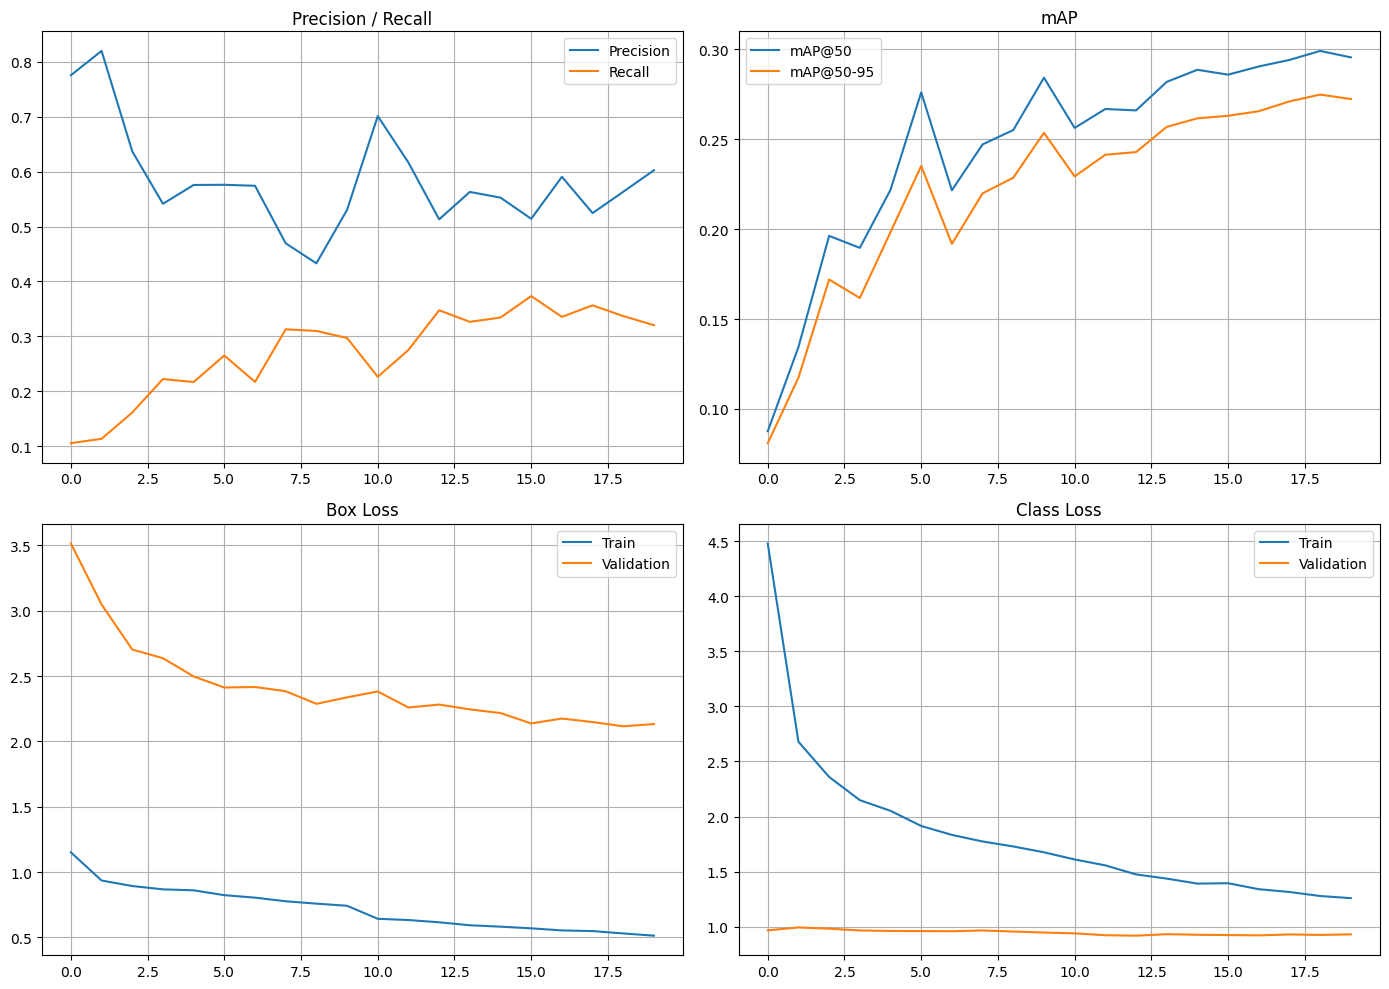

In [ ]:
display_stats(train_stats, val_stats)

Начнем анализ полученных значений с показаний метрик "Precision" и "Recall". Как видим, значение метрики "Precision" колеблется в диапазоне $[0.5; 0.7]$, в то время как значения метрики "Recall" - в диапазоне $[0.2, 0.35]$. Такие показания метрик говорят о том, что модель часто правильно классифицирует объект, которые **находит**. Однако, находит она их не слишком часто. То есть модель хорошо определяет "очевидные" объекты, но плохо справляется в более "сложных" сценариях.

Перейдем к метрике "Mean Average Precision". Значение метрики `mAP@0.5:0.95` находится в диапазоне $25 – 26 \%$. Это показывает, что модель способна делать точные локализации на разных IoU-порогах, но пока еще нуждается в дообучении или улучшении.

Касаемо значений ошибок. Значение ошибки "Box Loss" постепенно снижаются как для обучающей выборки, так и для валидационной. К тому же снижение происходит без резких скачков. Это свидетельствует о стабильной обучаемости модели без явного переобучения на обучающей выборке.

Касаемо ошибки "Class Loss", мы можем наблюдать, что она заметно снижается, в то время как валидационный датасет держится примерно на одном уровне без ухудшений. Здесь можно сделать вывод о том, что модель все еще способна к классификации объектов, но есть потенциал переобучиться.

Итого, модель показывает не плохие, но и не идеальные результаты. Возможным решением для улучшения бейзлайна может быть использование аугментации изображений, чтобы избежать переобучения.



Также, при работе с моделями, предназначенными для решения задачи обнаружения и распознования объектов, часто смотрят на кривую "Precision-Confidence". Данная кривая необходима, чтобы понять, насколько хорошо уверенность модели соответствует её реальной точности. Это помогает в выборе правильного порога для работы модели в production.

Посмотрим на данную кривую для обученной модели.

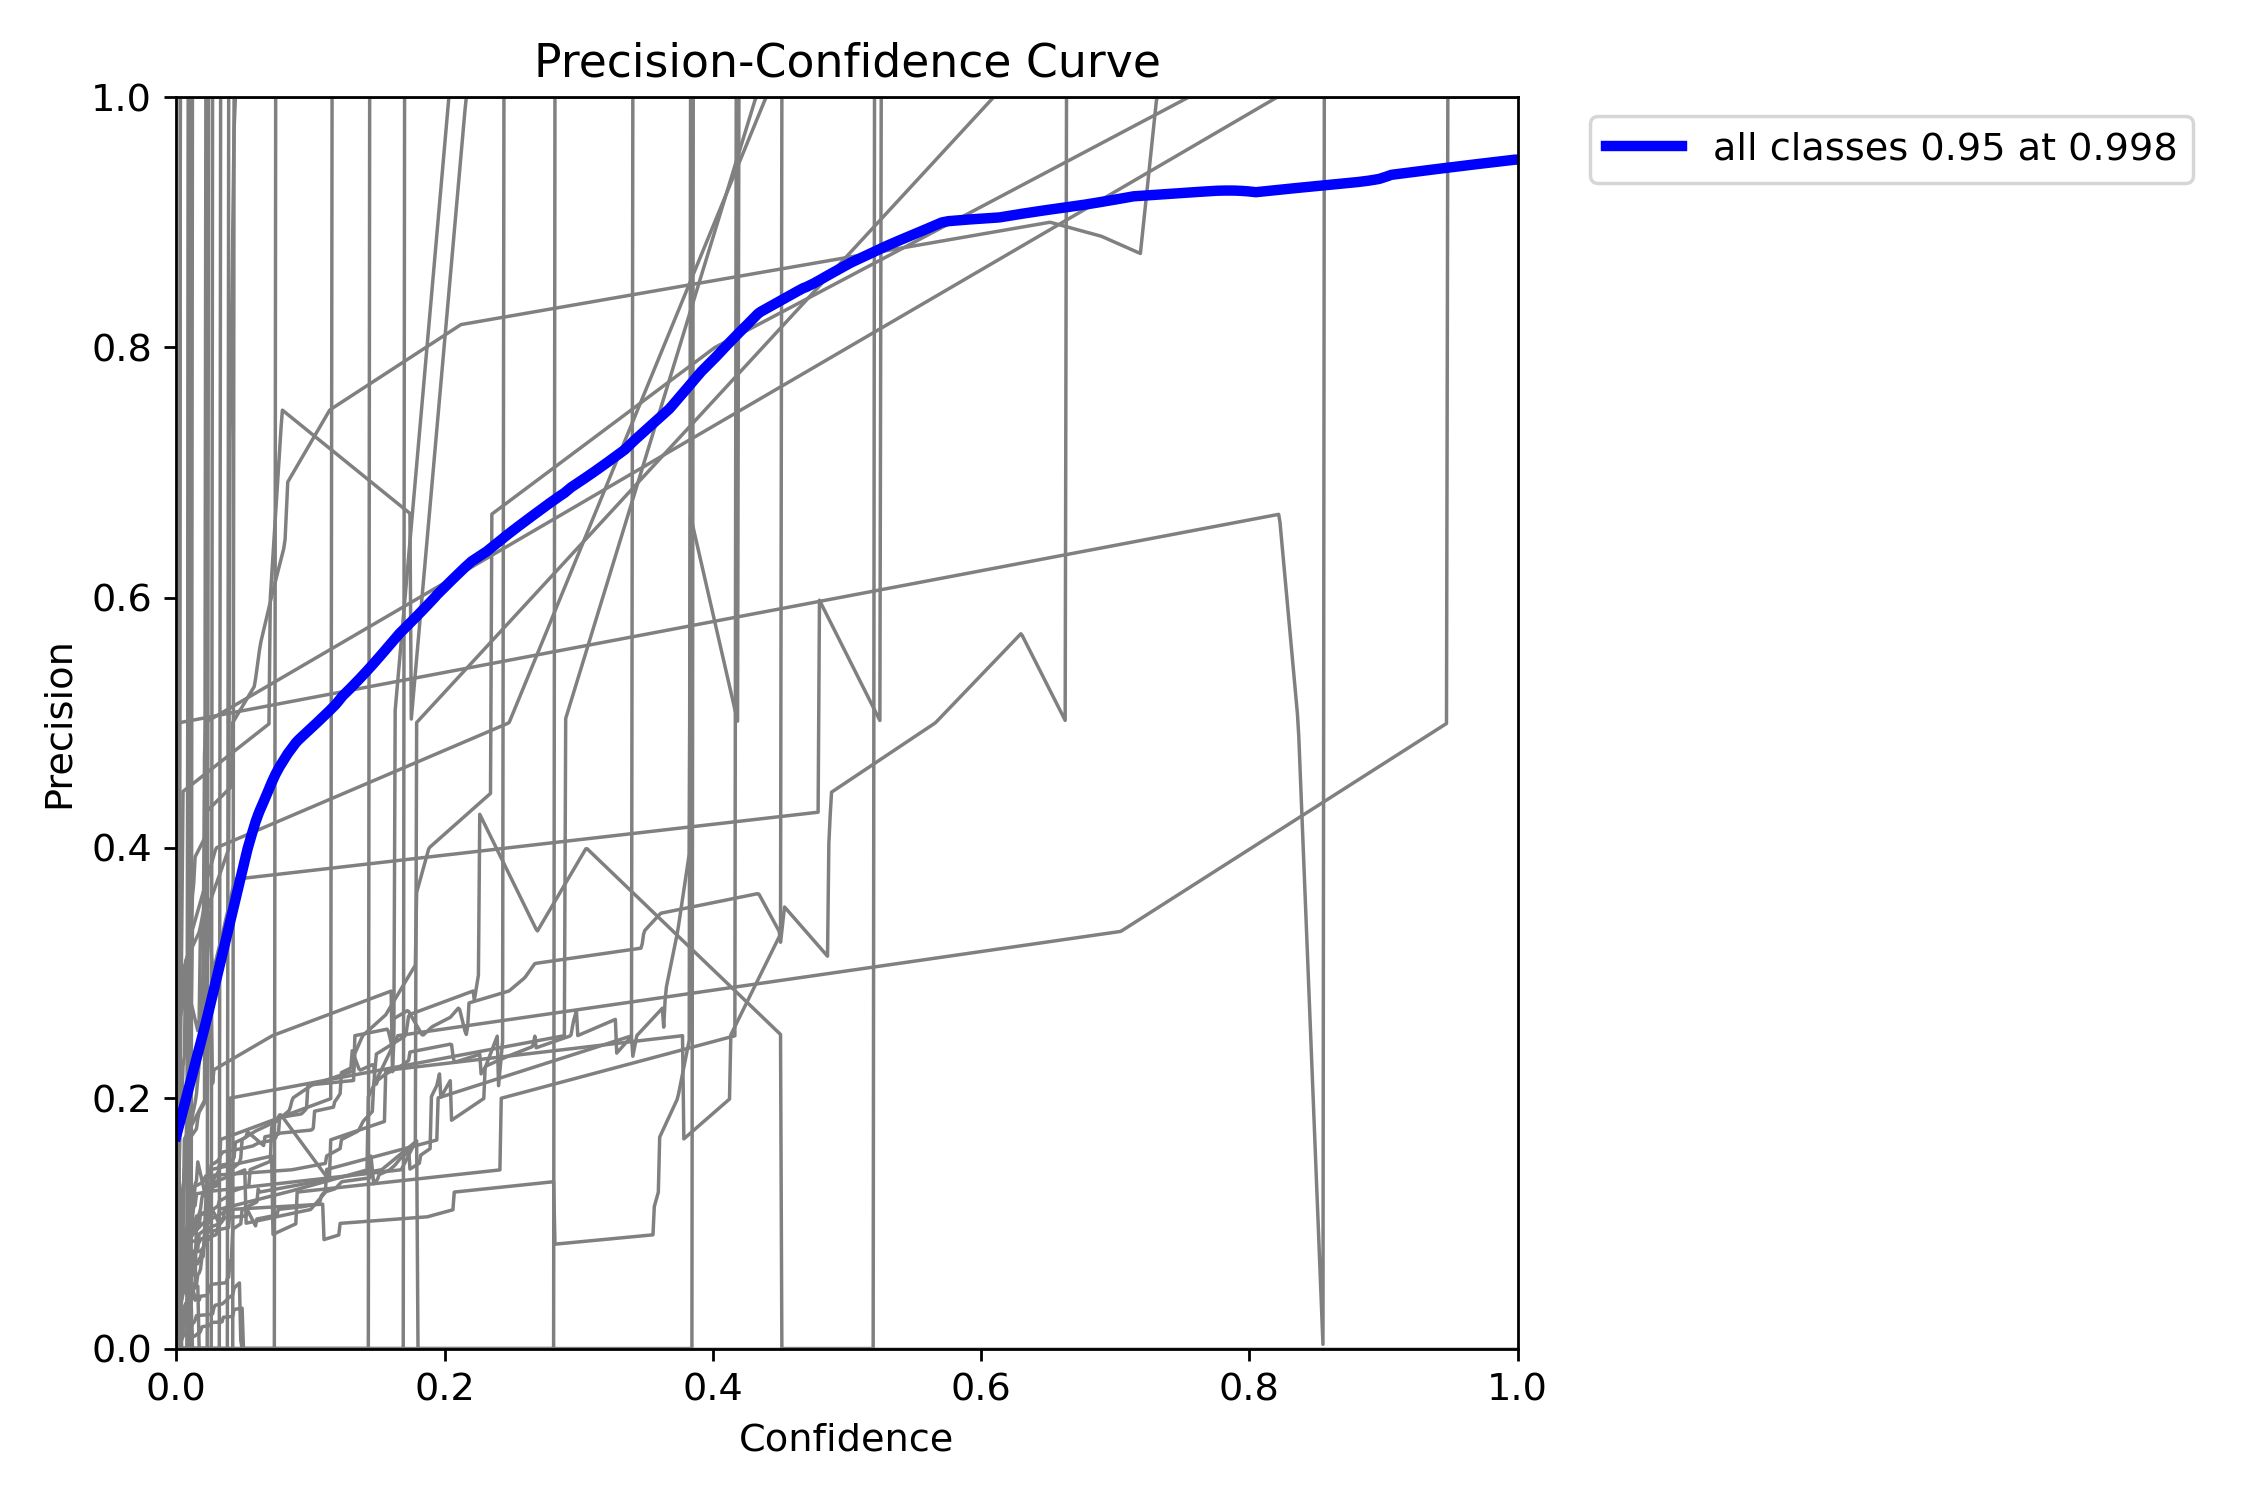

In [ ]:
Image.open(results.save_dir / 'P_curve.png')

Как видно на графике, при низких значениях "Confidence" значение "Precision" также остается низким. С ростом же значения "Confidence" до $0.5$ значение "Precision" уверенно растет до $\sim 80 \%$. При очень высоких значениях "Confidence", близких к $1$, значение "Precision" достигает $\sim 95 \%$.

Итого, если на production нам будет важна высокая точность, то нам необходимо будет выставить значение "Confidence Threshold", близкое к `0.9`. Если же нам необходимо, чтобы модель не пропускала объекты, то в этом случае более приоритетными будут значениям, близкие к `0.4`. Но также стоит учитывать, что в этом случае может упасть значение метрики "Precision".



## 3. Улучшение бейзлайна

### Аугметация изображений

Перейдем теперь к этапу улучшения бейзлайна. Как было описано в параграфе ранее, основной гипотезой по улучшению бейзлайна будет применение аугментации изображений.

Для этого создадим функцию `apply_augmentation`, которая будет принимать на вход пару `(image, bbox)`, где `image` - входное изображение, а `bbox` - соответствующий изображению boundary box в формате `[x, y, w, h]`, где каждое значение измеряется в пикселях.

Для реализации логики аугментации будет использоваться библиотека `albumentations`, так как она предоставляет более обширный функционал и позволяет применить одинаковые преобразования как к изображению, так и к boundary box.

In [ ]:
def _xywh_to_xyxy(bbox):
    x, y, w, h = bbox
    return [x, y, x + w, y + h]


def _xyxy_to_xywh(bbox):
    x_min, y_min, x_max, y_max = bbox
    return [x_min, y_min, x_max - x_min, y_max - y_min]


_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.1,
            rotate_limit=45,
            p=0.5,
        ),
    ],
    bbox_params=A.BboxParams(
        format='pascal_voc',
        label_fields=[],
    ),
)


def apply_augmentation(image, bbox):
    width, height = image.size
    image_np = np.array(image)

    bbox_xyxy = _xywh_to_xyxy(bbox)

    augmented = _transform(
        image=image_np,
        bboxes=[bbox_xyxy],
    )

    new_image = Image.fromarray(augmented['image'])
    out_bboxes = augmented["bboxes"]

    new_bbox_xyxy = augmented['bboxes'][0]
    new_bbox_xywh = _xyxy_to_xywh(new_bbox_xyxy)

    return new_image, new_bbox_xywh

Также, для визуального отображения изображения вместе с boundary box, напишем вспомогательную функцию `draw_bbox`.

In [ ]:
def draw_bbox(image, bbox, color='red', width=4):
    img_copy = image.copy()
    draw = ImageDraw.Draw(img_copy)

    x, y, w, h = bbox
    x1, y1 = x, y
    x2, y2 = x + w, y + h

    draw.rectangle(
        [x1, y1, x2, y2],
        outline=color,
        width=width,
    )

    return img_copy

Продемонстрируем работу аугментации на одном из семплов из обучающей выборки

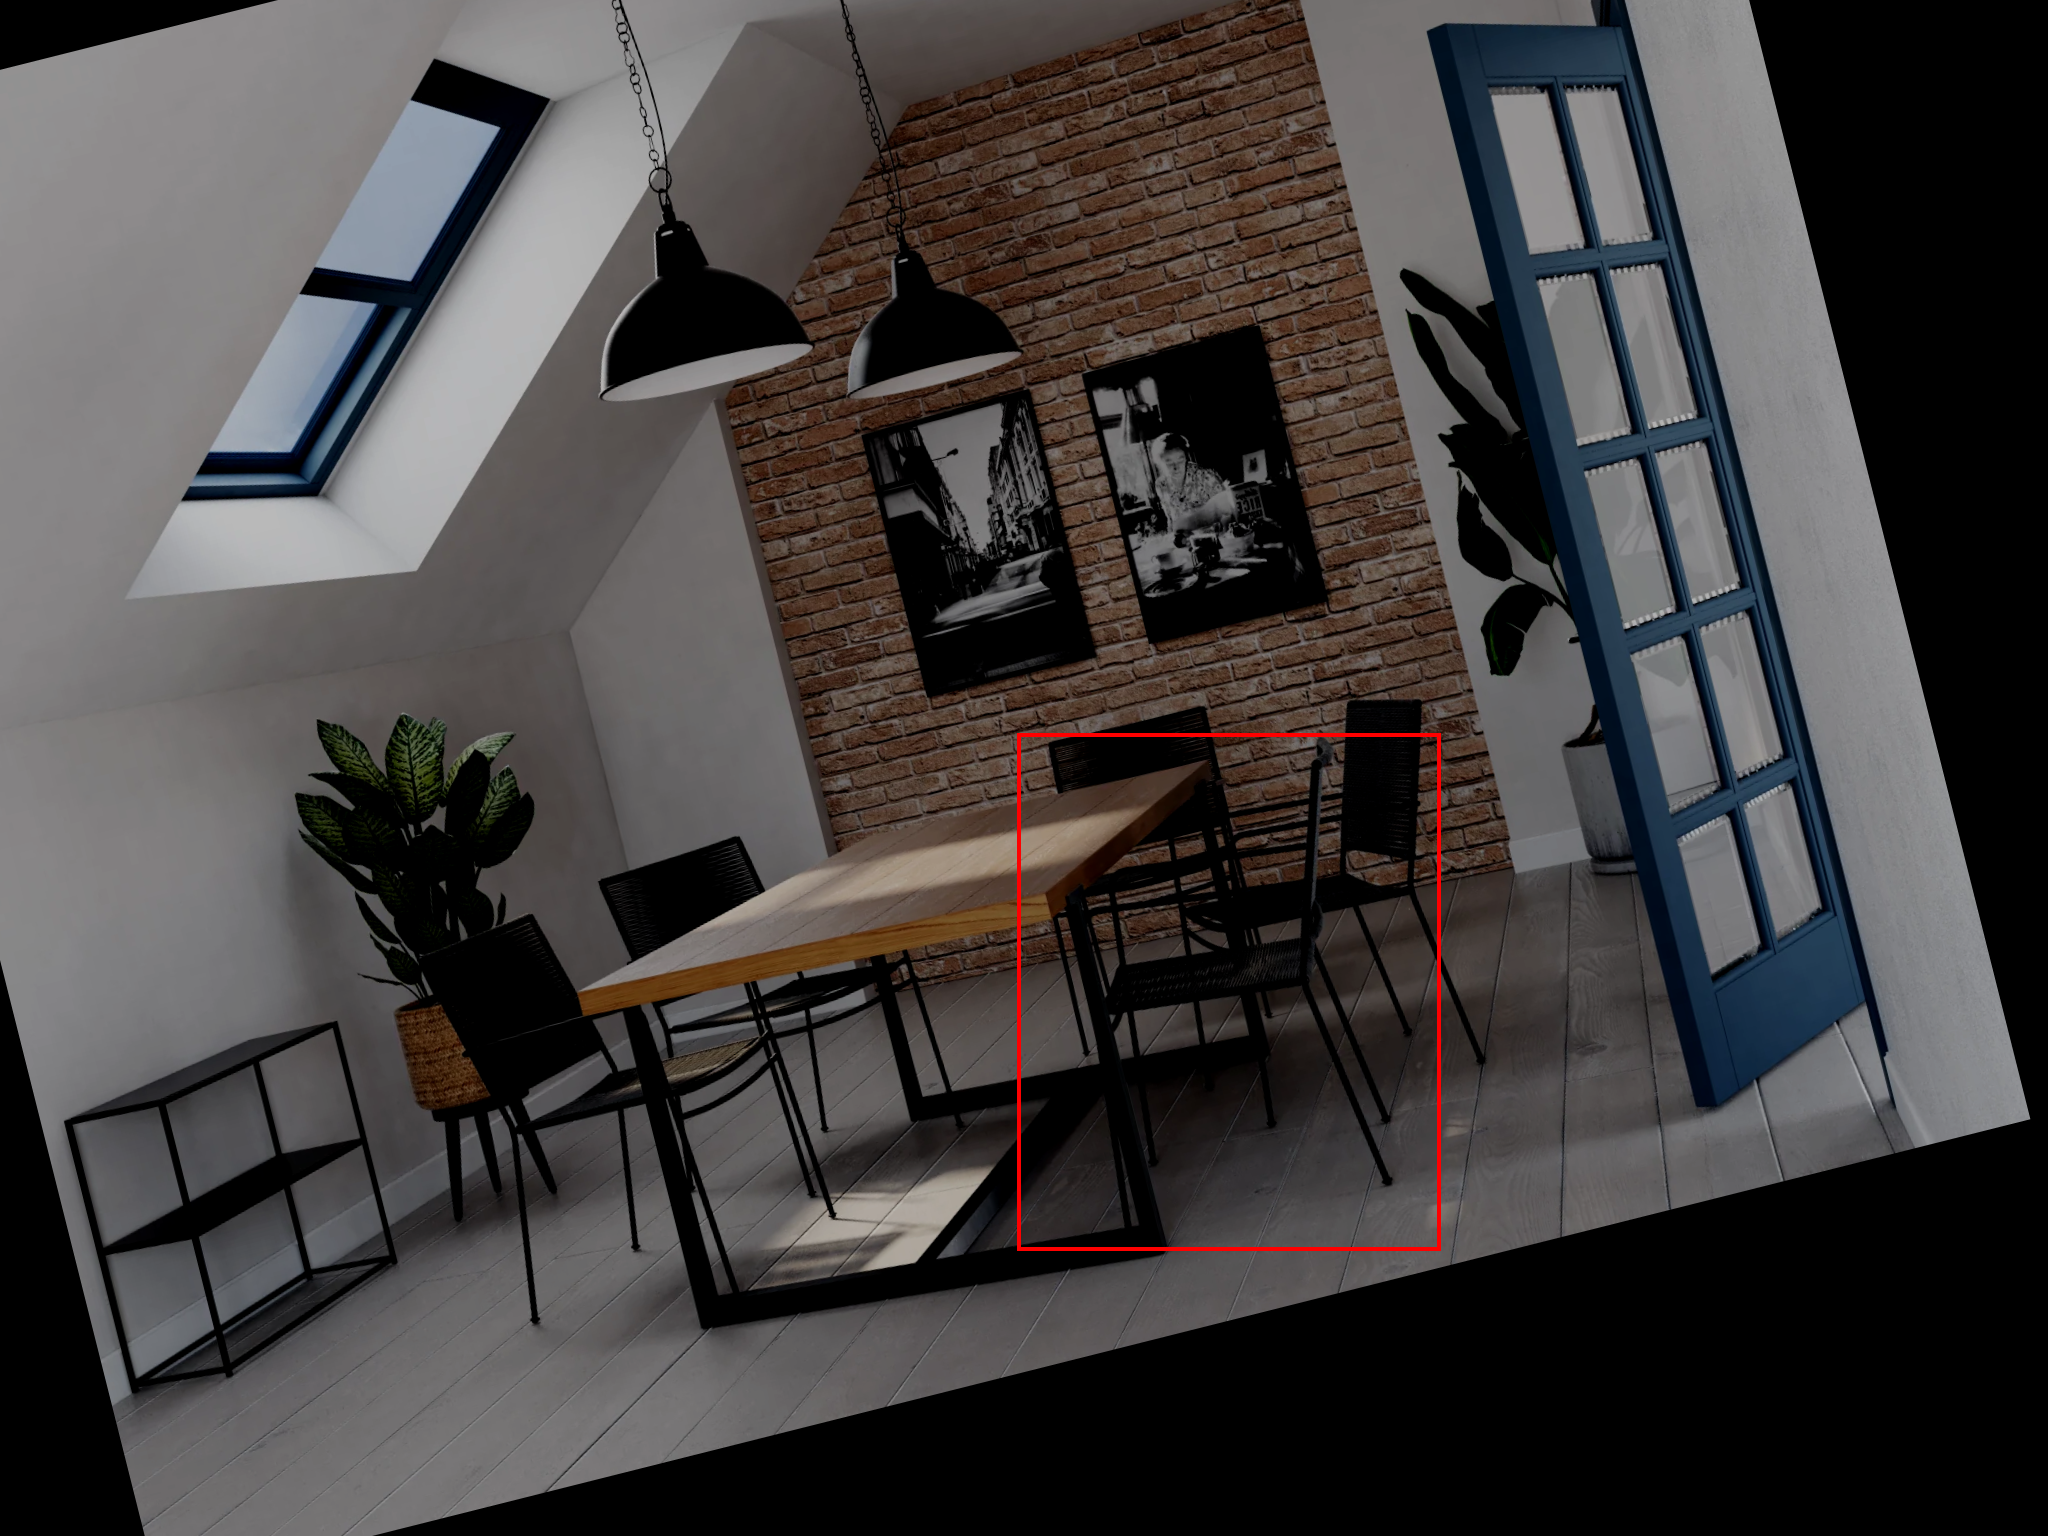

In [ ]:
element = train_dataset[0]
image, bbox = apply_augmentation(element['image'], element['bbox'])
draw_bbox(image, bbox)

Теперь, перейдем к формированию датасета. Для этого напишем вспомогательный класс `AugmentedDataset`, так как классовое представление датасета в данном случае самое выгодное из-за ленивых вычислений (данные датасета будут генерироваться "на ходу").

Данный класс будет поддерживать параметр `applies_amount`, соответствующий тому, сколько изображений будет сгенерировано через аугментацию. Далее, при получении каждого элемента по индексу, происходит определение того, является ли текущий элемент сгенерированным через аугментацию, либо это исходное изображение.

Если же текущий элемент является сгенерированным, то происходит непосредственно генерация этого элемента. В противном случае возвращается исходный элемент.

In [ ]:
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, ds, *, applies_amount=1):
        self._dataset = ds
        self._applies_amount = applies_amount

    def __len__(self):
        return len(self._dataset) * (1 + self._applies_amount)

    def __getitem__(self, idx):
        is_augmented = idx % (1 + self._applies_amount) != 0
        idx = idx // (1 + self._applies_amount)
        element = self._dataset[idx]
        image = element['image'].convert('RGB')
        bbox = element['bbox']
        category = element['category']

        if is_augmented:
            image, bbox = apply_augmentation(image, bbox)

        return {
            'image': image,
            'bbox': list(map(int, bbox)),
            'category': category,
        }

Наконец, сохраним обучающую выборку, содержащую сгенерированные изображения, вместе с валидационной выборкой в директорию для дальнейшего обучения модели.

In [ ]:
train_ds = AugmentedDataset(train_dataset)
val_ds = val_dataset
updated_dataset_path = Path('ds1')

save_dataset(train_ds, val_ds, updated_dataset_path)

Save val: 100%|██████████| 151/151 [00:13<00:00, 11.05it/s]


Теперь перейдем к этапу обучения модели. За основу я взял ту же модель `yolo11s`. Только на этот раз обучение будет происходить на датасете, расширенном сгенерированными изображениями. Также, я уменьшил количество эпох в 2 раза. Это обосновано тем, что размер обучающей выборки возросло в 2 раза.

In [ ]:
model = ultralytics.YOLO('yolo11s.pt')
results = model.train(
    data=updated_dataset_path / 'data.yaml',
    epochs=10,
    imgsz=225,
    batch=16,
    name='yolo11s-run-2',
    device=0,
)

New https://pypi.org/project/ultralytics/8.3.119 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.115 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=ds1/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=225, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolo11s-run-2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, sa

train: Scanning /kaggle/working/ds1/labels/train... 4126 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4126/4126 [00:02<00:00, 1415.60it/s]

train: New cache created: /kaggle/working/ds1/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1221.8±1011.7 MB/s, size: 293.4 KB)


val: Scanning /kaggle/working/ds1/labels/val... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<00:00, 1050.10it/s]

val: New cache created: /kaggle/working/ds1/labels/val.cache


Plotting labels to runs/detect/yolo11s-run-2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000227, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 4 dataloader workers
Logging results to runs/detect/yolo11s-run-2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.883G      1.101      4.273      1.121         14        256: 100%|██████████| 258/258 [00:38<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        151        151       0.65      0.218      0.147      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.932G      0.966      2.516      1.028         13        256: 100%|██████████| 258/258 [00:34<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.97it/s]


                   all        151        151       0.49      0.289      0.242      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.932G     0.9379       2.17      1.026         14        256: 100%|██████████| 258/258 [00:34<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.80it/s]


                   all        151        151      0.492      0.244      0.218      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.932G     0.9148      2.002      1.007         14        256: 100%|██████████| 258/258 [00:34<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.37it/s]


                   all        151        151      0.355      0.318       0.23      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10     0.979G     0.8646      1.847     0.9825         14        256: 100%|██████████| 258/258 [00:33<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.45it/s]


                   all        151        151      0.686      0.168      0.196      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10     0.979G     0.8192      1.723     0.9599         14        256: 100%|██████████| 258/258 [00:33<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.39it/s]

                   all        151        151      0.427      0.353      0.262      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10     0.979G     0.7697      1.606     0.9499         14        256: 100%|██████████| 258/258 [00:33<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.97it/s]

                   all        151        151      0.508      0.304      0.272       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10     0.979G     0.7215      1.494     0.9215         14        256: 100%|██████████| 258/258 [00:33<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.25it/s]

                   all        151        151      0.527      0.297        0.3      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10     0.979G     0.6923      1.419     0.9104         14        256: 100%|██████████| 258/258 [00:33<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.20it/s]


                   all        151        151      0.447      0.309       0.27      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10     0.979G     0.6627      1.369     0.9053         12        256: 100%|██████████| 258/258 [00:33<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.47it/s]

                   all        151        151      0.458      0.345      0.285      0.262



10 epochs completed in 0.101 hours.
Optimizer stripped from runs/detect/yolo11s-run-2/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/yolo11s-run-2/weights/best.pt, 19.2MB

Validating runs/detect/yolo11s-run-2/weights/best.pt...
Ultralytics 8.3.115 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,428,280 parameters, 0 gradients, 21.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.19it/s]


                   all        151        151      0.511      0.285       0.27      0.242
children's_toys_and_games          6          6          1          0     0.0914     0.0455
chandeliers,_candlesticks,_candles,_oils,_incense          1          1          1          0          0          0
children's_chairs_and_stools          1          1          1          0      0.199      0.199
cosmetics_and_beauty_products          3          3      0.116          1      0.199       0.19
                 sofas          9          9      0.823          1      0.918      0.808
 plant_pots_and_plants         17         17      0.203       0.42      0.399      0.302
         coffee_tables          2          2      0.426          1      0.828      0.795
frames_leaning_against_the_wall          1          1          1          0          0          0
   canvases,_paintings          9          9     0.0723      0.111      0.143       0.12
   office_organization          2          2          1   

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.0ms preprocess, 1.1ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/detect/yolo11s-run-2


Аналогично с бейзлайном, визуально продемонстрируем значения ошибок и метрик, которые собирались во время обучения модели.

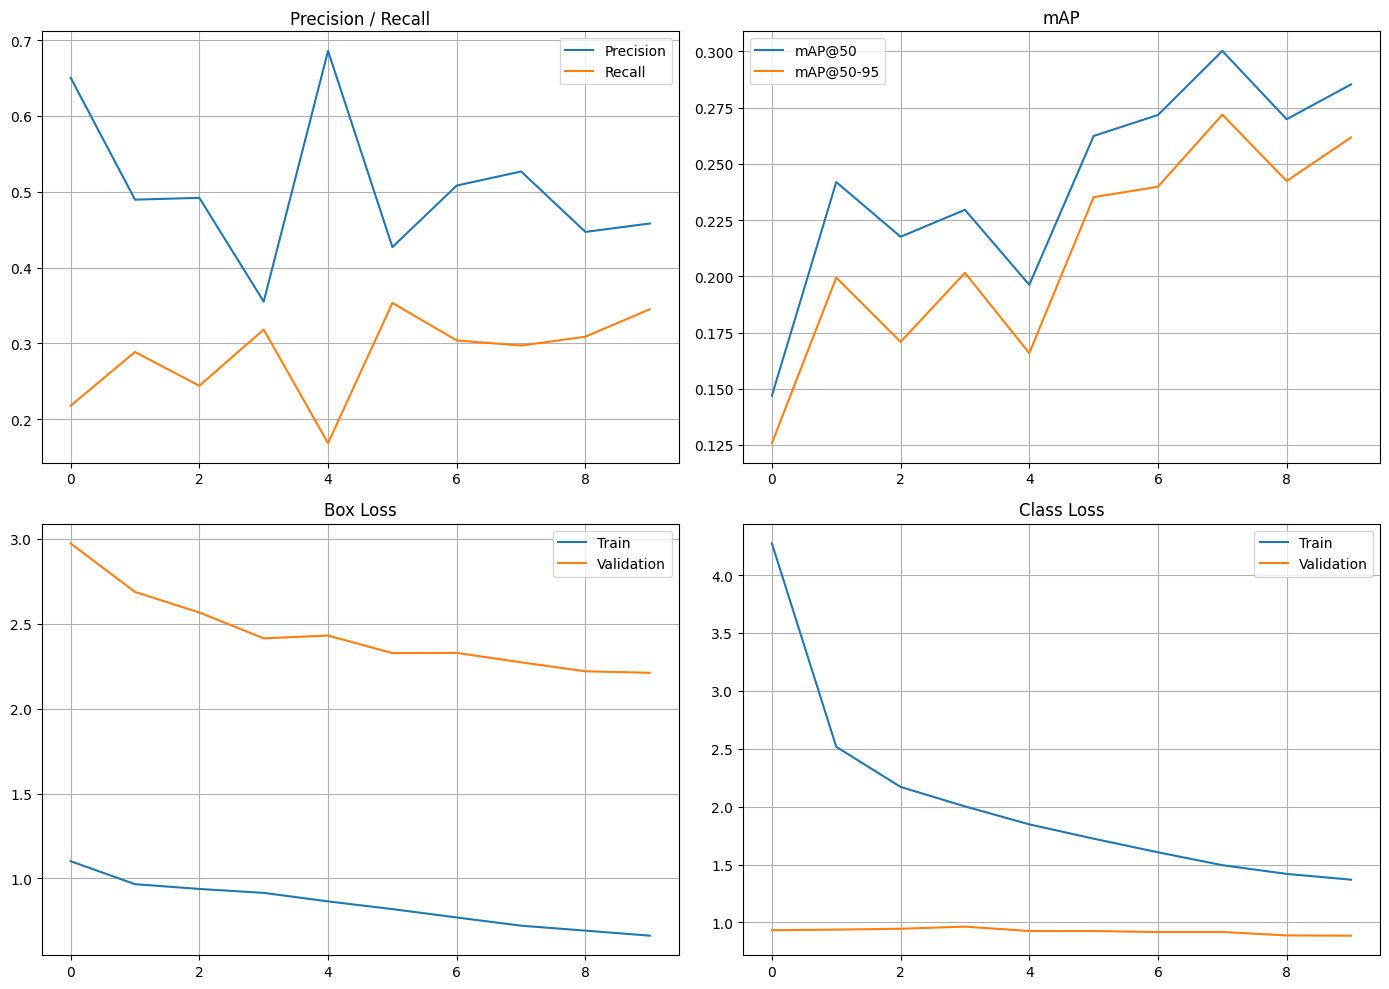

In [ ]:
train_stats = get_train_stats(results)
val_stats = get_val_stats(results)
display_stats(train_stats, val_stats)

Проанализируем полученные значения ошибок и метрик и сравним их с теми значениями, что мы получили при обучении модели на бейзлайне.

Касаемо метрики "mAP", в обоих случаях итоговые значения метрики сопоставимы. Однако, на исходном бейзлайне виден более плавный рост, по сравнению с улучшенным бейзлайном. На улучшенном же бейзлайне значения метрики чуть ниже, а колебания более выражены. Это может говорить о немного повышенной нестабильности обучения.

Касаемо метрики "Precision", мы можем заметить, что на улучшенном бейзлайне, ее показания в начале обучения выше по сравнению с обучением на бейзлайне. Однако, при обучении на бейзлайне, ее рост был более стабилен. Аналогичная ситуация и с метрикой "Recall".

Касаемо значений ошибок "Box Loss" и "Class Loss", мы можем заметить, что они практически идентичны для бейзлайна и улучшенного бейзлайна, что говорит о схожей способности к обобщению. Однако, на исходном бейзлайне снижение более выражено.

Итого, мы можем сказать, что улучшенный бейзлайн не дал явного прироста по ключевым метрикам, а местами даже показал менее стабильное обучение, которое выражается через скачки в показаниях метрик "Precision" и "mAP".

Продемонстрируем также кривую "Precision-Confidence" для модели, обученной на улучшенном бейзлайне.

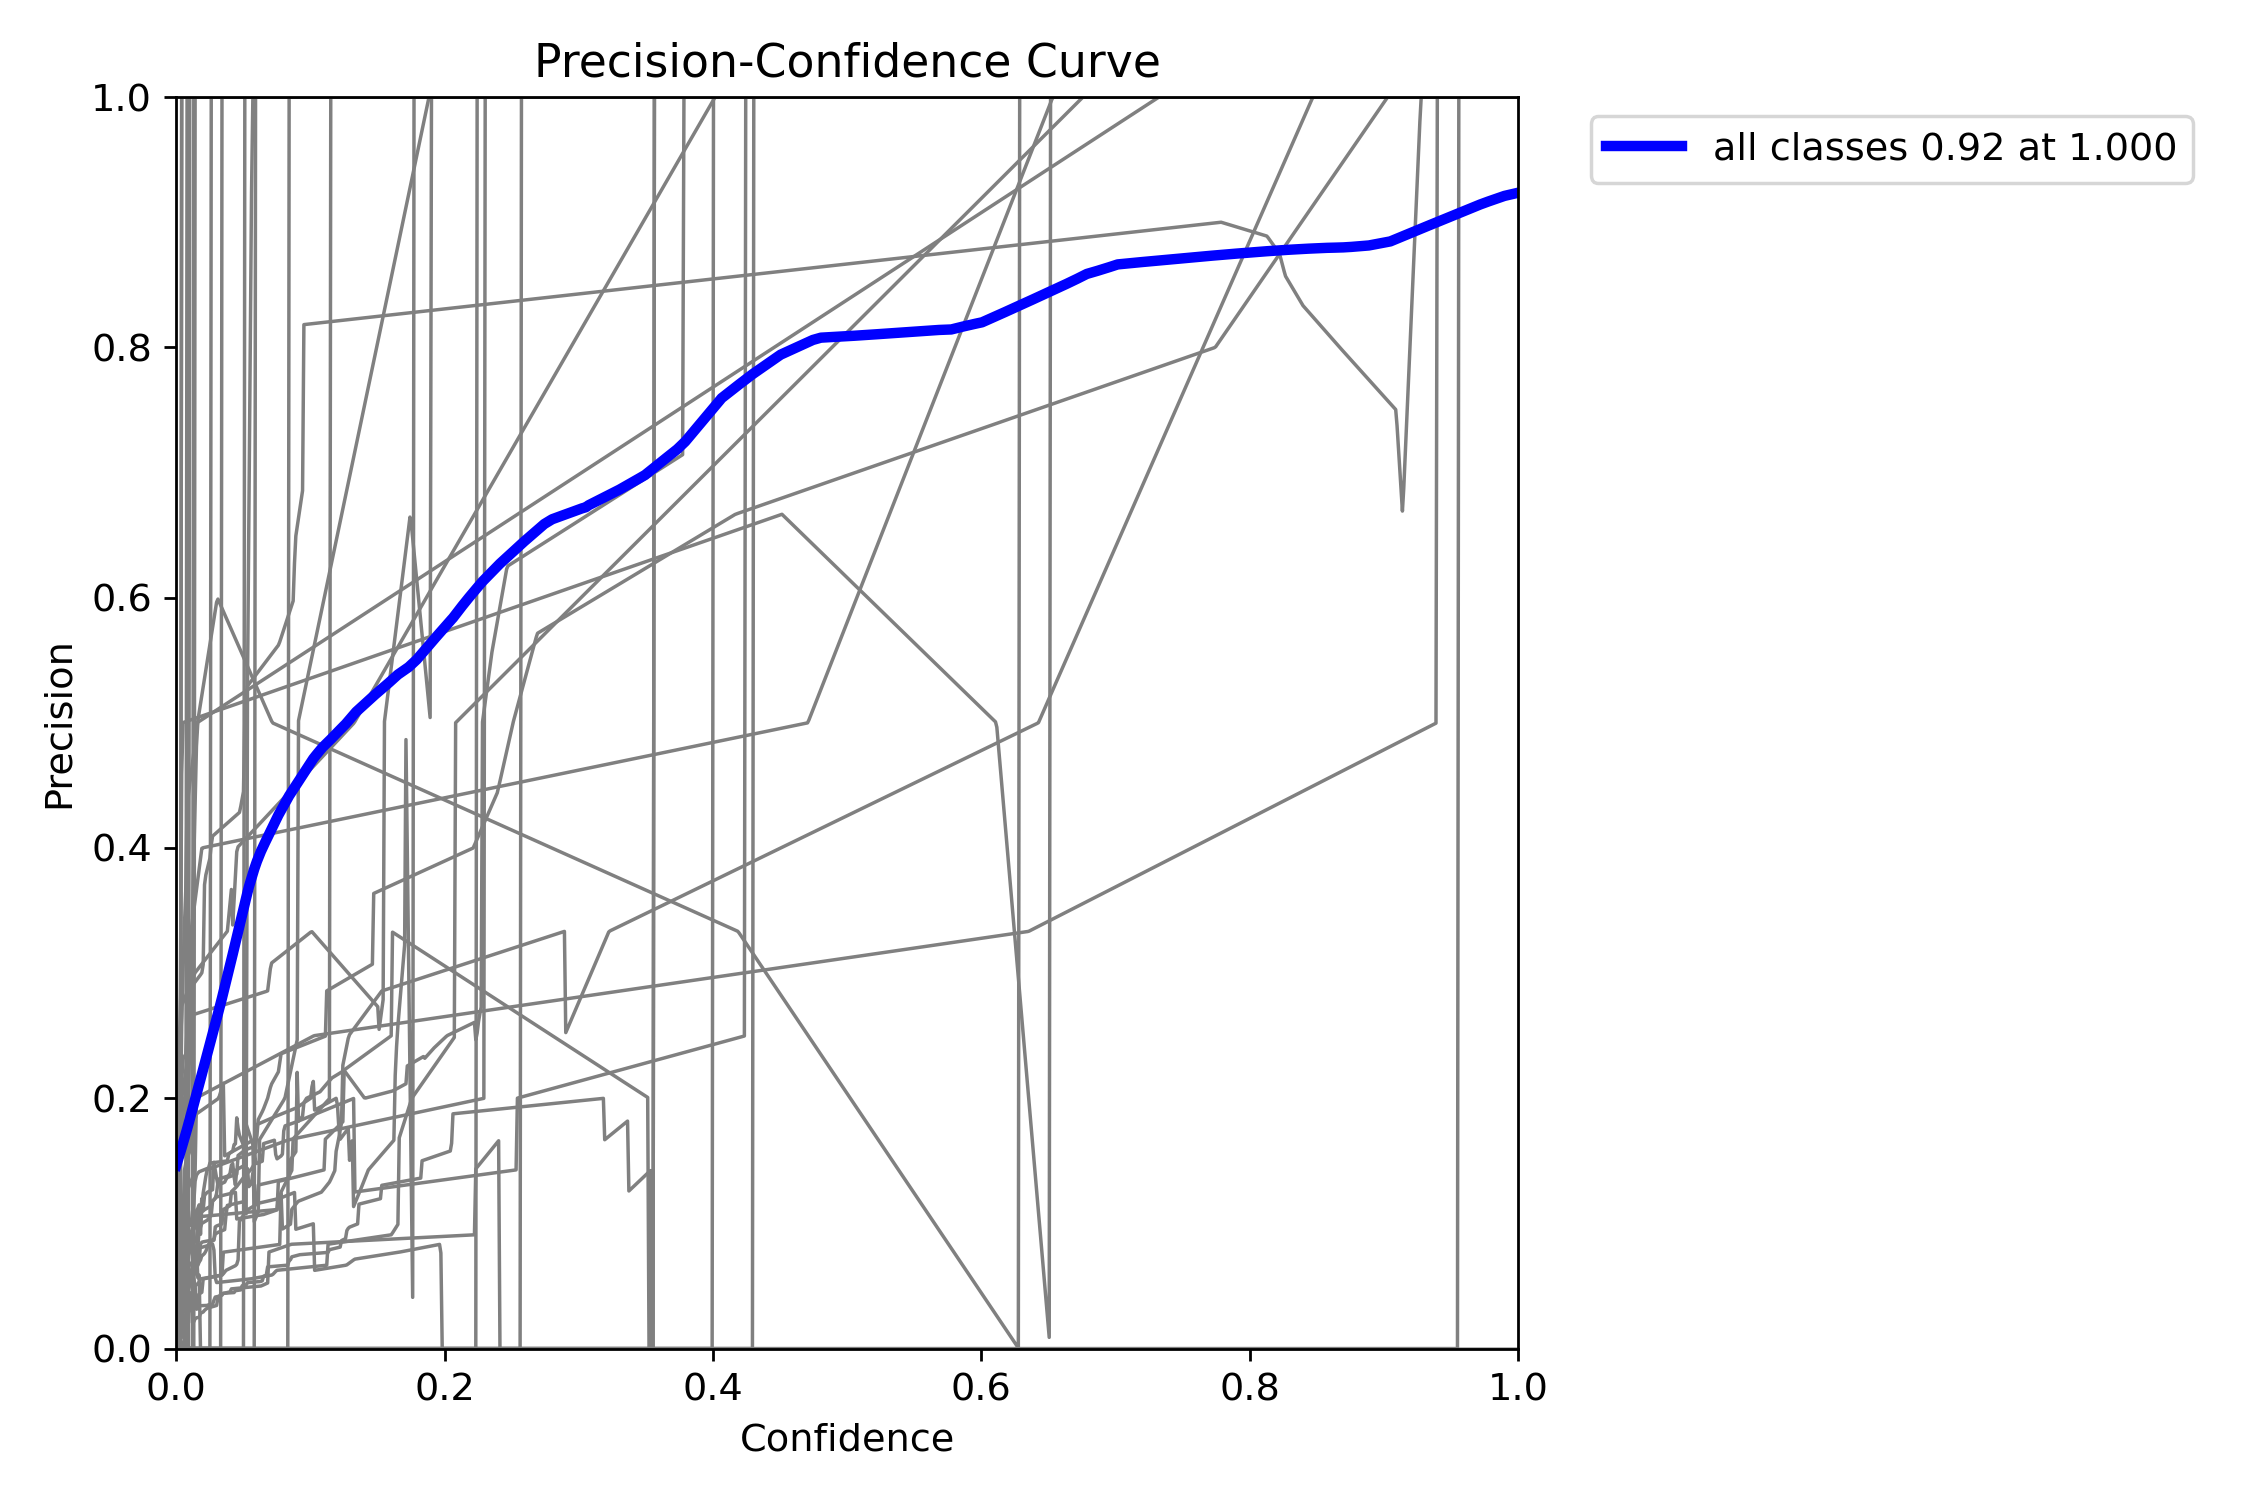

In [ ]:
Image.open(results.save_dir / 'P_curve.png')

Мы можем заметить, что по сравнению с "Precision-Confidence" кривой, полученной при обучении модели на исходном бейзлайне, кривая стала более "горбистой". Это может означать, что при изменении порого классификации модель стала демонстрировать более резкие изменения в точности и полноте.

Появившиеся "неровности" могут демонстрировать более выраженную чувствительность к порогу. Модель стала более уверенной в некоторых предсказаниях и менее уверенной в других, что вызывает резкие перепады "Precision" и "Recall" при смене порога.

## 4. Имплементация алгоритма машинного обучения

Перейдем теперь к имплементации собственного алгоритма машинного обучения для решения задачи обнаружения и распознования объектов.

Изначально был акцент на реализации архитектуры, похожей на ту, на основе которой были построены модели семейства YOLO. Однако, такие архитектуры были либо слишком сложны в реализации, либо не давали хотя бы минимальных результатов при обучении.

Поэтому было принято решение рассмотреть архитектуру "Detection Transformer". Данная архитектура сочетает в себе идеи сверточных нейронных сетей и трансформеров.

1. В основе моей модели лежит сверточная сеть "ResNet18". Она используется в начальном слое. Первые четыре основных блока предназначены для извлечения признаков из входного изображения.

2. Полученные признаки проходят через сверточный слой, который уменьшает число каналов до размерности скрытого пространства трансформера.

3. Далее признаки преобразуются в последовательность, где каждый элемент соответствует определенному пространственному положению, и подаются на вход энкодеру трансформера.

4. Энкодер же в свою очередь состоит из нескольких слоев с механизмом внимания, который позволяет модели учитывать глобальные взаимосвязи между различными частями изображения.

5. После этого используется декодер трансформера, который принимает на вход обучаемые эмбеддинги запросов. Эти запросы повторяются для каждого изображения в батче и служат для генерации представлений объектов.

6. На выходе декодера получается тензор, который затем преобразуется линейными слоями в предсказания классов объектов и координат ограничивающих рамок.

In [ ]:
def _build_backbone():
    backbone = torchvision.models.resnet18(pretrained=True)
    return torch.nn.Sequential(
        backbone.conv1,
        backbone.bn1,
        backbone.relu,
        backbone.maxpool,
        backbone.layer1,
        backbone.layer2,
        backbone.layer3,
        backbone.layer4,
    )

def _build_transformer_encoder(d_model=256, nhead=8, num_layers=6):
    return torch.nn.TransformerEncoder(
        torch.nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
        ),
        num_layers=num_layers,
    )

def _build_transformer_decoder(d_model=256, nhead=8, num_layers=6):
    return torch.nn.TransformerDecoder(
        torch.nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
        ),
        num_layers=num_layers,
    )

class DetrImplementation(torch.nn.Module):
    def __init__(self, queries_amount=20, num_classes=40, hidden_dim=256):
        super().__init__()
        self.backbone = _build_backbone()
        self.proj_conv = torch.nn.Conv2d(512, hidden_dim, kernel_size=1)
        self.encoder = _build_transformer_encoder(d_model=hidden_dim)
        self.decoder = _build_transformer_decoder(d_model=hidden_dim)
        self.query_embeddings = torch.nn.Parameter(torch.randn(queries_amount, hidden_dim))
        self.class_head = torch.nn.Linear(hidden_dim, num_classes)
        self.box_head = torch.nn.Linear(hidden_dim, 4)

    def encode(self, features):
        batch_size, channels, height, width = features.shape
        features_flat = features.flatten(2).permute(2, 0, 1)
        memory = self.encoder(features_flat)
        return memory

    def decode(self, memory, batch_size):
        queries = self.query_embeddings.unsqueeze(1).repeat(1, batch_size, 1)
        decoder_output = self.decoder(queries, memory)
        return decoder_output

    def forward(self, images):
        features = self.backbone(images)
        features = self.proj_conv(features)
        memory = self.encode(features)
        batch_size = images.size(0)
        decoder_output = self.decode(memory, batch_size)

        decoder_output = decoder_output.permute(1, 0, 2)
        class_logits = self.class_head(decoder_output)
        box_coords = self.box_head(decoder_output)

        return class_logits, box_coords


Также, реализуем ошибку, опираясь на которую, будет происходить обучение модели, в виде отдельного класса `DETRLoss`.

При написании данного класса я придерживался основного интерфейса, которому удовлетворяют все реализованные ошибки в PyTorch. Это касается и расположения логики по подсчету ошибки. Я ее разместил в dunderline-методе `__call__`. Данный метод на вход предсказанные логиты классов, координаты ограничивающих рамок и истинные метки объектов для каждого изображения в батче.

При подсчете ошибки из предсказаний берутся логиты и координаты первого объекта, а из истинных меток - первый объект с его классом и координатами.

Для вычисления ошибки классификации используется функция `cross_entropy`, которая сравнивает предсказанные логиты с истинным классом.

Для регрессии координат ограничивающей рамки же применяется `mse_loss`, измеряющая разницу между предсказанными и истинными координатами.


In [ ]:
class DetrLoss:
    def __init__(self, num_classes, device):
        self.num_classes = num_classes
        self.device = device

    def __call__(self, logits, boxes, labels):
        batch_loss = torch.tensor(0.0, device=self.device)
        cls_loss = torch.tensor(0.0, device=self.device)
        box_loss = torch.tensor(0.0, device=self.device)
        processed = 0

        for b in range(logits.size(0)):
            gt = labels[b]
            if gt.numel() == 0:
                continue

            cls_pred = logits[b, 0, :].unsqueeze(0)
            box_pred = boxes[b, 0, :]
            gt_item = gt[0].to(self.device)
            gt_cls = gt_item[0].long().unsqueeze(0)
            gt_box = gt_item[1:5]

            l_cls = F.cross_entropy(cls_pred, gt_cls)
            l_box = F.mse_loss(box_pred, gt_box)

            cls_loss += l_cls
            box_loss += l_box
            batch_loss += (l_cls + l_box)
            processed += 1

        assert processed

        batch_loss = batch_loss / processed
        cls_loss = cls_loss / processed
        box_loss = box_loss / processed

        return batch_loss, cls_loss, box_loss

Также, напишем в виде отдельного класса датасет, который преобразует входные данные к формату, пригодному для обучения модели.

При получении элементов датасета происходит:
- Нормализация изображения к формату $(480 \times 480)$
- Нормализация координат boundary box из формата `[x, y, w, h]` к формату `[x_start, y_start, x_end, y_end]`, где значения координат уже находятся в диапазоне $[0; 1]$.

In [ ]:
_transform_image = torchvision.transforms.Compose([
    torchvision.transforms.Resize((480, 480)),
    torchvision.transforms.ToTensor(),
])

def _normalize_bbox(image_size, bbox):
    image_width, image_height = image_size
    x_min, y_min, width, height = bbox

    x_center = x_min + width / 2
    y_center = y_min + height / 2

    return torch.tensor([
        x_center / image_width,
        y_center / image_height,
        width / image_width,
        height / image_height,
    ])

class DetrDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self._dataset = dataset

    def __len__(self):
        return len(self._dataset)

    def __getitem__(self, idx):
        element = self._dataset[idx]
        image = element['image'].convert('RGB')
        bbox = element['bbox']
        category = element['category']

        bbox = _normalize_bbox(image.size, bbox)
        image = _transform_image(image)
        label = torch.tensor([categories[category]])

        return image, torch.cat([label, bbox]).unsqueeze(0)

Наконец, опишем вспомогательные функции для обучения модели. Аналогично с прошлыми лабораторными работами, я придерживался такой архитектуры, чтобы функция возвращала значения ошибки и метрик на каждом шаге обучения. Это достигается за счет использования `yield`.

Функция `train_model` ответственна за обучение модели. Она принимает на вход целевую модель, датасет, соответствующий обучающей выборке, и функцию ошибки и оптимизатора. На каждом шаге функция возвращает словарь, содержащий информацию о значении ошибки и ее компонент, таких как `box_loss` и `cls_loss`.

Функция же `eval_model` ответсвенна за подсчет значений ошибки и метрик на валидационном датасете. Она принимает на вход модель и датасет, соответствующий валидационной выборке. На выходе же функция возвращает словарь, содержащий информацию о подсчитанной ошибке и показания метрик.

In [ ]:
def train_model(model, dataset, loss, optimizer):
    torch.cuda.empty_cache()
    model.train()

    total_loss = 0.0
    total_cls_loss = 0.0
    total_box_loss = 0.0
    samples_amount = 0

    for step_number, (images, labels) in enumerate(dataset, 1):
        batch_size = images.size(0)
        images = images.to(DEVICE)
        optimizer.zero_grad()

        logits, boxes = model(images)
        assert torch.isfinite(logits).all(), 'Non-finite logits detected'
        assert torch.isfinite(boxes).all(), 'Non-finite boxes detected'

        batch_loss, cls_loss, box_loss = loss(logits, boxes, labels)
        if batch_loss is None:
            continue

        assert torch.isfinite(batch_loss), 'Non-finite loss detected'
        batch_loss.backward()
        optimizer.step()

        total_loss += batch_loss.item() * batch_size
        total_cls_loss += cls_loss.item() * batch_size
        total_box_loss += box_loss.item() * batch_size
        samples_amount += batch_size

        yield {
            'step': step_number,
            'loss': {
                'total': total_loss / samples_amount,
                'cls': total_cls_loss / samples_amount,
                'box': total_box_loss / samples_amount,
            },
        }


def _map_metric(model, val_loader):
    metric = MeanAveragePrecision(iou_type='bbox')

    for images, labels in val_loader:
        batch_size = images.size(0)
        images = images.to(DEVICE)
        preds_logits, preds_boxes = model(images)

        preds, targets = [], []
        for index in range(batch_size):
            pred_boxes = preds_boxes[index]
            pred_scores = preds_logits[index].softmax(dim=-1)
            pred_labels = pred_scores.argmax(dim=-1)

            preds.append({
                "boxes": pred_boxes.cpu(),
                "scores": pred_scores.max(dim=-1).values.cpu(),
                "labels": pred_labels.cpu(),
            })

            gt = labels[index]
            if gt.numel() == 0:
                targets.append({
                    "boxes": torch.zeros((0, 4)),
                    "labels": torch.zeros((0,), dtype=torch.long),
                })
            else:
                targets.append({
                    "boxes": gt[:, 1:5].cpu(),
                    "labels": gt[:, 0].long().cpu(),
                })

        metric.update(preds, targets)

    result = metric.compute()
    return {
        'map_50': result['map_50'].item(),
        'map': result['map'].item(),
    }


@torch.no_grad()
def eval_model(model, val_loader, loss):
    model.eval()

    total_loss = 0.0
    total_cls_loss = 0.0
    total_box_loss = 0.0
    samples_amount = 0

    for images, labels in val_loader:
        batch_size = images.size(0)
        images = images.to(DEVICE)
        logits, boxes = model(images)

        batch_loss, cls_loss, box_loss = loss(logits, boxes, labels)
        if batch_loss is None:
            continue

        assert torch.isfinite(batch_loss), 'Non-finite loss detected'
        total_loss += batch_loss.item() * batch_size
        total_cls_loss += cls_loss.item() * batch_size
        total_box_loss += box_loss.item() * batch_size
        samples_amount += batch_size

    return {
        'loss': {
            'total': total_loss / samples_amount,
            'cls': total_cls_loss / samples_amount,
            'box': total_box_loss / samples_amount,
        },
        'metrics': _map_metric(model, val_loader),
    }

### Обучение на бейзлайне

Наконец, обучим реализованную модель на бейзлайне

In [1]:
model = DetrImplementation(
    queries_amount=20,
    num_classes=len(categories),
)

model = model.to(DEVICE)

loss = DetrLoss(
    num_classes=len(categories),
    device=DEVICE,
)

train_loader = torch.utils.data.DataLoader(
    DetrDataset(train_dataset),
    batch_size=8,
    shuffle=False,
)

val_loader = torch.utils.data.DataLoader(
    DetrDataset(val_dataset),
    batch_size=8,
    shuffle=False,
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    train_logs = train_model(
        model,
        train_loader,
        DetrLoss(
            num_classes=len(categories),
            device=DEVICE,
        ),
        optimizer,
    )

    for logs in train_logs:
        print(
            '\rEpoch: {epoch}, Step [{step} / {steps_amount}], loss={loss:.4f}, cls_loss={cls_loss:.4f}, box_loss={box_loss:.4f}'.format(
                epoch=epoch,
                step=logs['step'],
                steps_amount=len(train_loader),
                loss=logs['loss']['total'],
                cls_loss=logs['loss']['cls'],
                box_loss=logs['loss']['box'],
            ), end='')
    print()

    results = eval_model(model, val_loader, loss)
    print('Validation: loss={loss:.4f}, cls_loss={cls_loss:.4f}, box_loss={box_loss:.4f}, mAP50={map_50:.4f}, mAP={map:.4f}'.format(
        loss=results['loss']['total'],
        cls_loss=results['loss']['cls'],
        box_loss=results['loss']['box'],
        map_50=results['metrics']['map_50'],
        map=results['metrics']['map'],
    ))

Epoch: 0, Step [258 / 258], loss=3.2317, cls_loss=3.1713, box_loss=0.0604
Validation: loss=4.4779, cls_loss=3.8480, box_loss=0.6299, mAP50=0.0626, mAP=0.0691
Epoch: 1, Step [258 / 258], loss=3.2173, cls_loss=3.1573, box_loss=0.0600
Validation: loss=3.7612, cls_loss=3.7245, box_loss=0.0367, mAP50=0.1269, mAP=0.1508
Epoch: 2, Step [258 / 258], loss=3.1731, cls_loss=3.1237, box_loss=0.0493
Validation: loss=3.8380, cls_loss=3.8035, box_loss=0.0345, mAP50=0.1491, mAP=0.1698
Epoch: 3, Step [258 / 258], loss=3.1574, cls_loss=3.1099, box_loss=0.0475
Validation: loss=3.8025, cls_loss=3.7685, box_loss=0.0341, mAP50=0.1559, mAP=0.1654
Epoch: 4, Step [258 / 258], loss=3.0954, cls_loss=3.0468, box_loss=0.0487
Validation: loss=3.8119, cls_loss=3.7780, box_loss=0.0339, mAP50=0.1803, mAP=0.1983
Epoch: 5, Step [258 / 258], loss=3.1254, cls_loss=3.0790, box_loss=0.0464
Validation: loss=3.8457, cls_loss=3.8115, box_loss=0.0342, mAP50=0.1686, mAP=0.1903
Epoch: 6, Step [258 / 258], loss=3.1315, cls_loss=3.

Как видно, модель показала относительно хуже результаты на бейзлайне по сравнению с моделью YOLOv11.

Однако, судя по стабильному уменьшению значений функции потерь на обучающей и валидационной выборках, можно сказать о том, что модель успешно оптимизируется и учится лучше соответствовать данным.

Это особенно заметно по `cls_loss` и `box_loss` на валидации. Данные значения говорят о том, что модель все еще сохраняет способность к обобщению.

Касаемо значений метрик "mAP", в начале обучения они имели достаточно низкие значения, однако по мере обучения их показатели росли. Это указывает на то, что модель все еще способна к выделению объектов и их распознованию на классы, хотя качество предсказаний все еще невысоко.

Итого, модель показала относительно неплохие результаты на бейзлайне, но гораздо хуже по сравнению с моделью YOLOv11. Это может быть обоснованно упрощенной архитектурой и тем, что трансформерные модели, на которых основана наша имплементация, требуют гораздо более долгого обучения.

### Обучение на улучшенном бейзлайне

Попробуем теперь обучить модель на улучшенном бейзлайне

In [13]:
model = DetrImplementation(
    queries_amount=20,
    num_classes=len(categories),
)

model = model.to(DEVICE)

loss = DetrLoss(
    num_classes=len(categories),
    device=DEVICE,
)

train_loader = torch.utils.data.DataLoader(
    DetrDataset(train_ds),
    batch_size=8,
    shuffle=False,
)

val_loader = torch.utils.data.DataLoader(
    DetrDataset(val_dataset),
    batch_size=8,
    shuffle=False,
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(5):
    train_logs = train_model(
        model,
        train_loader,
        DetrLoss(
            num_classes=len(categories),
            device=DEVICE,
        ),
        optimizer,
    )

    for logs in train_logs:
        print(
            '\rEpoch: {epoch}, Step [{step} / {steps_amount}], loss={loss:.4f}, cls_loss={cls_loss:.4f}, box_loss={box_loss:.4f}'.format(
                epoch=epoch,
                step=logs['step'],
                steps_amount=len(train_loader),
                loss=logs['loss']['total'],
                cls_loss=logs['loss']['cls'],
                box_loss=logs['loss']['box'],
            ), end='')
    print()

    results = eval_model(model, val_loader, loss)
    print('Validation: loss={loss:.4f}, cls_loss={cls_loss:.4f}, box_loss={box_loss:.4f}, mAP50={map_50:.4f}, mAP={map:.4f}'.format(
        loss=results['loss']['total'],
        cls_loss=results['loss']['cls'],
        box_loss=results['loss']['box'],
        map_50=results['metrics']['map_50'],
        map=results['metrics']['map'],
    ))

Epoch: 0, Step [516 / 516], loss=3.2577, cls_loss=3.1923, box_loss=0.0654
Validation: loss=3.9344, cls_loss=3.8712, box_loss=0.0632, mAP50=0.0508, mAP=0.0661
Epoch: 1, Step [516 / 516], loss=3.2038, cls_loss=3.1456, box_loss=0.0582
Validation: loss=3.8676, cls_loss=3.8323, box_loss=0.0353, mAP50=0.1312, mAP=0.1437
Epoch: 2, Step [516 / 516], loss=3.1266, cls_loss=3.0721, box_loss=0.0545
Validation: loss=3.8532, cls_loss=3.8187, box_loss=0.0345, mAP50=0.1618, mAP=0.1867
Epoch: 3, Step [516 / 516], loss=3.2496, cls_loss=3.1964, box_loss=0.0532
Validation: loss=3.8154, cls_loss=3.7812, box_loss=0.0342, mAP50=0.1551, mAP=0.1921
Epoch: 4, Step [516 / 516], loss=3.1237, cls_loss=3.0778, box_loss=0.0459
Validation: loss=3.8306, cls_loss=3.7965, box_loss=0.0341, mAP50=0.1852, mAP=0.2034


Как видим, при использовании улучшенного бейзлайна результат похож на тот, что мы получили при обучении модели `yolov11s`.

Значения ошибок на обучении и валидации находятся примерно на том же уровне, что и у обычного бейзлайна: `cls_loss` и `box_loss` постепенно уменьшаются, при этом `box_loss` стал чуть ниже на валидации.

Метрики "mAP" демонстрируют положительную динамику. Однако, по сравнению с результатами, полученными на обычном бейзлайне, улучшенный бейзлайн показывает чуть более низкие значения метрик.

Итого, можно сказать, что изменения в улучшенном бейзлайне либо незначительно влияют на итоговое качество модели, либо они требуют более длительного обучения для проявления преимуществ.